In [ ]:
import pandas as pd
import numpy as np

In [ ]:
file1 = '2022_Problem_C_DATA/BCHAIN-MKPRU.csv'
file2 = '2022_Problem_C_DATA/LBMA-GOLD.csv'
f1 = pd.read_csv(file1)
f2 = pd.read_csv(file2)


In [ ]:
print(f1.iloc[0:10])
print(f2.iloc[0:10])


      Date   Value
0  9/11/16  621.65
1  9/12/16  609.67
2  9/13/16  610.92
3  9/14/16  608.82
4  9/15/16  610.38
5  9/16/16  609.11
6  9/17/16  607.04
7  9/18/16  611.58
8  9/19/16  610.19
9  9/20/16  608.66
      Date  USD (PM)
0  9/12/16   1324.60
1  9/13/16   1323.65
2  9/14/16   1321.75
3  9/15/16   1310.80
4  9/16/16   1308.35
5  9/19/16   1314.85
6  9/20/16   1313.80
7  9/21/16   1326.10
8  9/22/16   1339.10
9  9/23/16   1338.65


In [ ]:
def insert(df, i, df_add):
    # 指定第i行插入一行数据
    df1 = df.iloc[:i, :]
    df2 = df.iloc[i:, :]
    df_new = pd.concat([df1, df_add, df2], ignore_index=True)
    return df_new


def data_reform(f1, f2):
    index = 0
    Test = f2
    for i in range(len(f1['Date'])):
        if i == 0:
            continue
        if f1['Date'][i] != f2['Date'][index]:
            df_add = [{'Date': f1['Date'][i],
                       'USD (PM)': f2['USD (PM)'][index-1]}]
            df_add = pd.DataFrame(df_add)
            Test = insert(Test, i-1, df_add)
        else:
            index += 1
    return Test



In [ ]:
f2 = data_reform(f1, f2)

In [ ]:
print(f2.iloc[0:15])

       Date  USD (PM)
0   9/12/16   1324.60
1   9/13/16   1323.65
2   9/14/16   1321.75
3   9/15/16   1310.80
4   9/16/16   1308.35
5   9/17/16   1308.35
6   9/18/16   1308.35
7   9/19/16   1314.85
8   9/20/16   1313.80
9   9/21/16   1326.10
10  9/22/16   1339.10
11  9/23/16   1338.65
12  9/24/16   1338.65
13  9/25/16   1338.65
14  9/26/16   1340.50


In [ ]:
f2.to_csv('2022_Problem_C_DATA/LBMA-GOLD_CLEAN.csv')

In [ ]:
import numpy
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import pandas as pd
import os
from keras import models
from keras.models import Sequential, load_model
from sklearn.preprocessing import MinMaxScaler


In [ ]:
dataset1 = f1['Value'].values
# 将整型变为float
dataset1 = dataset1.astype('float32')
dataset1 = dataset1.reshape(-1, 1)
# 归一化
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset1)

dataset2 = f2['USD (PM)'].values
# 将整型变为float
dataset2 = dataset2.astype('float32')
dataset2 = dataset2.reshape(-1, 1)
# 归一化
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset2)


In [ ]:
def iter_bit(dataset1, look_back):
    data_bit_X, data_bit_Y = [], []
    for i in range(len(dataset1)-look_back-1):
        a = dataset1[i:(i+look_back)]
        data_bit_X.append(a)
        data_bit_Y.append(dataset1[i + look_back:i + look_back + 1])
    return numpy.array(data_bit_X), numpy.array(data_bit_Y)


def iter_gold(dataset2, look_back):
    data_gold_X, data_gold_Y = [], []
    for i in range(len(dataset2)-look_back-1):
        a = dataset2[i:(i+look_back)]
        data_gold_X.append(a)
        data_gold_Y.append(dataset2[i + look_back:i + look_back + 1])
    return numpy.array(data_gold_X), numpy.array(data_gold_Y)


In [ ]:
train_bit_X, train_bit_Y = iter_bit(dataset1, 5)
train_gold_X, train_gold_Y = iter_bit(dataset1, 5)


In [ ]:
print(train_bit_X[0:3])
print(train_bit_Y[0:3])

[[[621.65]
  [609.67]
  [610.92]
  [608.82]
  [610.38]]

 [[609.67]
  [610.92]
  [608.82]
  [610.38]
  [609.11]]

 [[610.92]
  [608.82]
  [610.38]
  [609.11]
  [607.04]]]
[[[609.11]]

 [[607.04]]

 [[611.58]]]


In [ ]:
# create and fit the LSTM network
class Model_bit:
    def __init__(self, train_bit_X, train_bit_Y):
        self.model = Sequential()
        self.model.add(LSTM(4, input_shape=(5,1)))
        self.model.add(Dense(1))
        self.model.compile(loss='mean_squared_error', optimizer='adam')
        self.train_bit_X = train_bit_X
        self.train_bit_Y = train_bit_Y

    def train(self, day, batch_size=1):
        train_X = self.train_bit_X[0:day]
        train_Y = self.train_bit_Y[0:day]
        for i in range(50):
            self.model.fit(train_X, train_Y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
            self.model.reset_states()

    def predict(self, day):
        # 反归一化
        pred_X = self.train_bit_X[day-1:day]
        pred_X = numpy.reshape(pred_X, (1, 5, 1))
        trainPredict = self.model.predict(pred_X)
        return scaler.inverse_transform(trainPredict)


class Model_gold:
    def __init__(self, train_gold_X, train_gold_Y):
        self.model = Sequential()
        self.model.add(LSTM(4, input_shape=(None, 1)))
        self.model.add(Dense(1))
        self.model.compile(loss='mean_squared_error', optimizer='adam')
        self.train_bit_X = train_gold_X
        self.train_bit_Y = train_gold_Y

    def train(self, day, batch_size=1):
        train_X = self.train_gold_X[0:day]
        train_Y = self.train_gold_Y[0:day]
        self.model.fit(train_X, train_Y, epochs=5,
                       batch_size=batch_size, verbose=0, shuffle=False)
        self.model.reset_states()

    def predict(self, day):
        # 反归一化
        trainPredict = self.model.predict(self.train_gold_X[0:day])
        return scaler.inverse_transform(trainPredict)


#model_bit.save(os.path.join("Model", "Bit" + ".h5"))
# make predictions


In [ ]:
model_bit = Model_bit(train_bit_X, train_bit_Y)
model_gold = Model_gold(train_gold_X, train_gold_Y)

In [ ]:
model_bit.train(600)


In [ ]:
predict = []

for i in range(10):
    predict.append(model_bit.predict(600+i))


In [ ]:
print(predict)
print(f1.iloc[600:610])

[array([[38452.59]], dtype=float32), array([[38452.59]], dtype=float32), array([[38452.59]], dtype=float32), array([[38452.59]], dtype=float32), array([[38452.59]], dtype=float32), array([[38452.59]], dtype=float32), array([[38452.59]], dtype=float32), array([[38452.59]], dtype=float32), array([[38452.59]], dtype=float32), array([[38452.59]], dtype=float32)]
        Date        Value
600   5/4/18  9753.350000
601   5/5/18  9803.306667
602   5/6/18  9630.136277
603   5/7/18  9631.440000
604   5/8/18  9228.608333
605   5/9/18  9322.041667
606  5/10/18  9310.370000
607  5/11/18  8468.788000
608  5/12/18  8484.346667
609  5/13/18  8463.520000


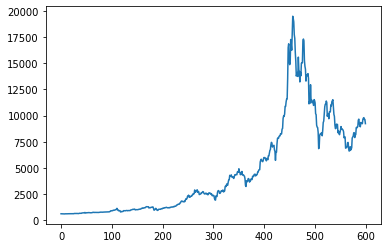

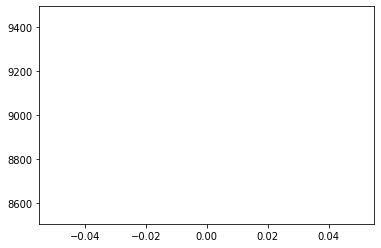

In [ ]:
plt.plot(train_bit_Y.reshape(1820)[:600])
plt.show()
plt.plot(predict)
plt.show()


In [111]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=5):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	print(new_row)
	array = numpy.asarray(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """


In [37]:
# load dataset
series = read_csv('BCHAIN-MKPRU.csv', header=0, index_col=0, squeeze=True)
print(series.head())

Date
9/11/16    621.65
9/12/16    609.67
9/13/16    610.92
9/14/16    608.82
9/15/16    610.38
Name: Value, dtype: float64


In [38]:
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

In [39]:
print(raw_values)

[  621.65   609.67   610.92 ... 46809.17 46078.38 46368.69]


In [43]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 5)
supervised_values = supervised.values

In [45]:
print(supervised.shape)

(1825, 6)


In [46]:
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

In [47]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [48]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [49]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 100, 4)

In [54]:
print(train_scaled.shape)

(1813, 6)


In [50]:
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

ValueError: ignored

In [51]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Month=1, Predicted=49221.931163, Expected=48806.780000
Month=2, Predicted=49248.066183, Expected=47074.770000
Month=3, Predicted=47503.975060, Expected=47155.870000
Month=4, Predicted=46768.594574, Expected=48862.760000
Month=5, Predicted=49146.106577, Expected=49329.010000
Month=6, Predicted=49605.278980, Expected=50035.330000
Month=7, Predicted=50332.537391, Expected=49947.380000
Month=8, Predicted=50321.031879, Expected=51769.060000
Month=9, Predicted=52025.075800, Expected=52677.400000
Month=10, Predicted=53106.269795, Expected=46809.170000
Month=11, Predicted=47602.375476, Expected=46078.380000
Month=12, Predicted=46010.038856, Expected=46368.690000


In [147]:
pred7 = []
X = test_scaled[0, 0:6].reshape(1,1,6)
tag = raw_values[-12]
for i in range(12):
  yhat = lstm_model.predict(X)
  for i in range(5):
    X[:,:,i] = X[:,:,i+1]
  X[:,:,5] = yhat
  y = scaler.inverse_transform(X.reshape(1,6))
  #y = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
  y = y[:,5].reshape(1)
  y = tag + y
  tag = y
  pred7.append(y)

In [148]:
print(pred7)

[array([50603.89177332]), array([49902.14080677]), array([50019.58019417]), array([48937.29628431]), array([49967.71431495]), array([48945.73463038]), array([49621.08032932]), array([48553.3057093]), array([51161.14496062]), array([50650.91678963]), array([51834.35973522]), array([51612.88208135])]


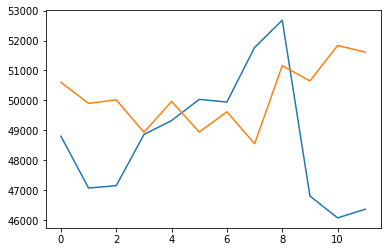

In [149]:
pyplot.plot(raw_values[-12:])
pyplot.plot(pred7)
pyplot.show()

In [19]:
print(len(test_scaled))

12


In [17]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 1998.384


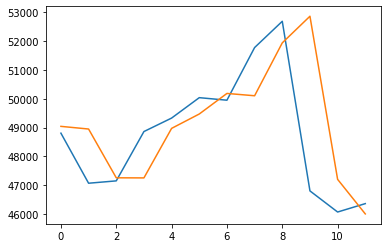

In [23]:
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()